In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
from data_load import load
import scipy.io as io
# Load matplotlib images inline
%matplotlib inline
# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Section \#1.3: Multi-Class Logistic Regression and Adaboost 

Please follow our instructions in the same order to solve the linear regresssion problem.

Please print out the entire results and codes when completed.

In [6]:
from data_loadM import load_mnist
X_train,X_test,y_train,y_test=load_mnist()
print('Train data shape: ', X_train.shape)
print('Train target shape: ', y_train.shape)
print('Test data shape: ',X_test.shape)
print('Test target shape: ',y_test.shape)

Train data shape:  (60000, 784)
Train target shape:  (60000,)
Test data shape:  (10000, 784)
Test target shape:  (10000,)


**ANSWER** The dimension of the training set is: (60000, 784) and the test set is: (10000, 784).

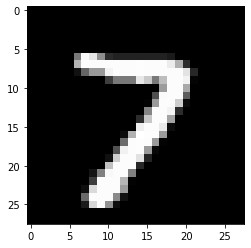

label is 7


In [7]:
# To Visualize a point in the dataset
index = 4000
X = np.array(X_train[index], dtype='uint8')
X = X.reshape((28, 28))
fig = plt.figure()
plt.imshow(X, cmap='gray')
plt.show()
fig.savefig('Sample.pdf')
print('label is', y_train[index])

## Train Multi-Class Logistic Regression

In the following cells, you will build a Multi-Class logistic regression. You will implement its loss function, then subsequently train it with gradient descent. You will implement L1 norm regularization, and choose the best regularization parameter.

In [22]:
from MLogistic import MLogistic

In [23]:
## Complete loss_and_grad function in MLogistic.py file and test your results.
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

logistic = MLogistic(dim=[num_classes,num_features], reg_param=0)
loss, grad = logistic.loss_and_grad(X_train[:5000],y_train[:5000])
print('Loss function=',loss)
print('Frobenius norm of grad=',np.linalg.norm(grad))
##

Loss function= 2.3025850929939837
Frobenius norm of grad= 269.57149388566296


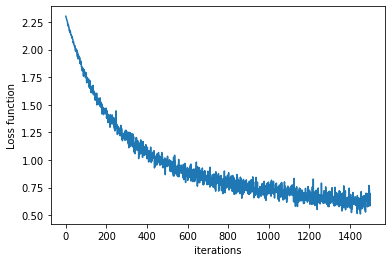

0.013278785268794387
0.6371785831753499


In [24]:
## Complete train_LR function in MLogistic.py file 
loss_history, w = logistic.train_LR(X_train,y_train, eta=1e-7,batch_size=200, num_iters=1500)
fig = plt.figure()
plt.plot(loss_history)
plt.xlabel('iterations')
plt.ylabel('Loss function')
plt.show()
print(np.linalg.norm(w))
print(loss_history[1499])

**ANSWER** The final value of the loss function is 0.013 and the value L2 of the weight is 0.637.


In [25]:
# ================================================================ #
# YOUR CODE HERE:
#Complete predict function in MLogistic.py file and compute the trainin error and the test error
# ================================================================ #

def get_acc(logistic, inputs, target):
    preds = logistic.predict(inputs)
    acc = 100 * sum(preds.astype(int) == target)/len(target)
    return acc

print(f"Train Error: {100 - get_acc(logistic, X_train, y_train)}")
print(f"Test Error: {100 - get_acc(logistic, X_test, y_test)}")

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


60000
Train Error: 13.99666666666667
10000
Test Error: 12.909999999999997


Note that here the test error is lower than the train error, which is unexpected. We looked into the dataset and noticed that the last $10,000$ samples of the training set (i.e X_train[50000:]) corresponded to X_test, leading to improved performance on the test set.

In [20]:
reg = [0,1e-6,1e-3,1e-2,1e-1,1]
train_err =np.zeros((len(reg),1))
test_err =np.zeros((len(reg),1))
# ================================================================ #
# YOUR CODE HERE:
# complete the following code to plot both the training and test loss in the same plot
# for m range from 1 to 10
# ================================================================ #
for m in range(0,len(reg)):
    logistic = MLogistic(dim=[num_classes,num_features], reg_param=reg[m])
    loss_history, w = logistic.train_LR(X_train,y_train, eta=1e-7,batch_size=200, num_iters=3000)
    train_err[m] = get_acc(logistic, X_train, y_train)
    test_err[m] = get_acc(logistic, X_test, y_test)
    


60000
10000
60000
10000
60000
10000
60000
10000
60000
10000
60000
10000


Text(0, 0.5, 'Error')

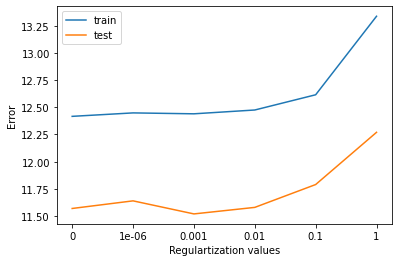

In [21]:
# Bad naming, here train_err and test_err actually refer to the accuracy
plt.plot(100 - train_err, label='train')
plt.plot(100 - test_err, label='test')
plt.legend()
plt.xlabel('Regulartization values')
results = list(map(str, reg))
plt.xticks(np.arange(len(results)), results)
plt.ylabel('Error')

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

**ANSWER** The regularization value that seems to work best is $0.001$. The minimum value of the test error on the MNIST dataset is around $11.5\%$. Again, as mentioned earlier, there was overlap between the training and test set, with the data provided, which lead to the unusual instance that the test set error was lower than the training set.


In [7]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
import pdb

T = 200
N = X_train.shape[0]
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]
train_err = np.zeros((T,1))
test_err = np.zeros((T,1))
# ================================================================ #
# YOUR CODE HERE:
# complete the following code to plot both the training and test loss in the same plot
# as a function of number of classifiers T for Adaboost Algorithm. 
# ================================================================ #

#Initialize
D = np.ones_like(y_train)/len(y_train)
alphas = np.zeros((T,1))
classifiers = []
errors = np.zeros((T,1))
total_test_predictions = np.zeros((10000, 10))
total_train_predictions = np.zeros((60000, 10))
train_errors = np.zeros((T,1))
test_errors = np.zeros((T,1))

for t in range(0,T):
    #Train decision Tree
    tree = DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train, sample_weight = D)
    classifiers.append(tree)
    
    #Compute error
    train_predictions = tree.predict(X_train)
    errors[t] = np.sum((train_predictions != y_train) * D)
    
    #Compute \alpha
    alphas[t] = np.log((1 - errors[t])/errors[t]) + np.log(9) #K=10 classes
    
    #Update weights
    D = D * np.exp(alphas[t] * (train_predictions != y_train))
    D = D/np.sum(D)
    
    #Predict using Last t classifiers
    test_predictions = classifiers[t].predict(X_test)
    total_test_predictions[np.arange(10000), test_predictions] += alphas[t]
    final_test_predictions = np.argmax(total_test_predictions, axis=1)
    
    total_train_predictions[np.arange(60000), train_predictions] += alphas[t]
    final_train_predictions = np.argmax(total_train_predictions, axis=1)

    #compute test error and train error
    train_errors[t] = np.sum(final_train_predictions != y_train)
    test_errors[t] = np.sum(final_test_predictions != y_test)



First error: [41.01166667]
Last error: [6.20166667]


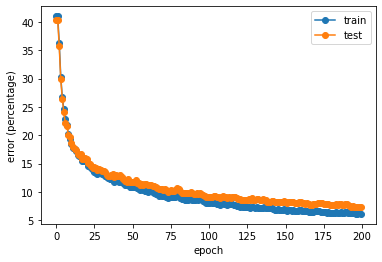

In [66]:
# Plot test error and train error in the same plot vs T


plt.plot(100 * train_errors/len(y_train), marker='o', label='train')
plt.plot(100 * test_errors/len(y_test), marker='o', label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('error (percentage)')

print(f"First error: {100 * train_errors[0]/len(y_train)}")
print(f"Last error: {100 * train_errors[-1]/len(y_train)}")

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

**ANSWER** The first error was: 41.01% and the last error was: 6.20%